In [8]:
import torch, os
import torch.nn.functional as F
import lightning as pl
from einops import rearrange
import matplotlib.pyplot as plt
from tqdm import tqdm

from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision.datasets import MNIST

from modules.trainers.DDPM import DDPM

In [2]:
model = DDPM.load_from_checkpoint('/home/exouser/genmod/genmod/m890eba3/checkpoints/last.ckpt')
model.eval()

DDPM(
  (nn_model): UViT(
    (down1): UnetDown(
      (model): Sequential(
        (0): ResidualBlock(
          (residual_block): Sequential(
            (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.2, inplace=True)
            (2): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          )
        )
        (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): GroupNorm(8, 64, eps=1e-05, affine=True)
      )
    )
    (patch_to_embedding): Sequential(
      (0): Rearrange('b c h w -> b c (h w)', h=14, w=14)
      (1): Linear(in_features=196, out_features=64, bias=True)
    )
    (time_embedding): Sequential(
      (0): EmbedFC(
        (model): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=64

100%|██████████| 999/999 [00:03<00:00, 278.51it/s]


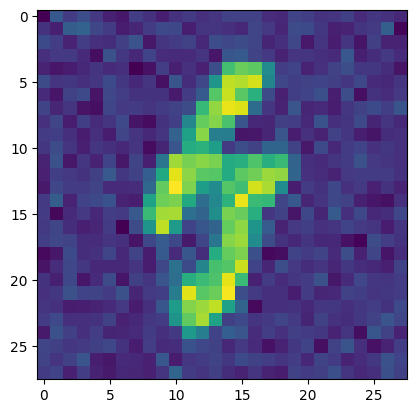

In [9]:
device = "cuda:0"

torch.cuda.empty_cache()

model = model.to(device)

x_i = torch.randn((1,1,28,28)).to(device)  # x_T ~ N(0, 1), sample initial noise
for i in tqdm(range(model.n_T-1, 0, -1)):
    t_is = torch.tensor([i / model.n_T]).to(device)
    t_is = t_is.repeat(x_i.size(0),1,1,1)

    z = torch.randn_like(x_i).to(device) if i > 1 else 0

    eps = model.nn_model(x_i, t_is)
    x_i = (
        model.oneover_sqrta[i] * (x_i - eps * model.mab_over_sqrtmab[i])
        + model.sqrt_beta_t[i] * z
    )

x_0 = x_i.detach().cpu().numpy().squeeze().squeeze()
plt.imshow(x_0)